Thank you Sachin for getting me started with your public notebook: Flower Classification with TPUs

# **Libraries**

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, time, csv

import tensorflow as tf
from kaggle_datasets import KaggleDatasets

AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.1.0


# **Hardware details**

Running on TPU  grpc://10.0.0.2:8470

REPLICAS:  8

GCS DS PATH::
 gs://kds-a44744780cb28b908f65e7fa3b4a473ef199bb9ffe8048dbbf29ffeb
GCS PATH::
 gs://kds-a44744780cb28b908f65e7fa3b4a473ef199bb9ffe8048dbbf29ffeb/tfrecords-jpeg-512x512
1e-05 1.0000000303056348e-05


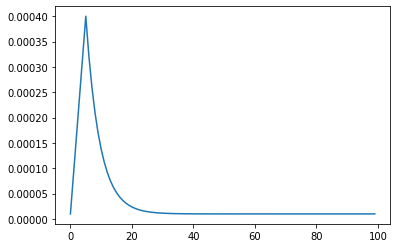

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    
IMAGE_PIXELS = 512
    
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_PIXELS]

print("\nREPLICAS: ", strategy.num_replicas_in_sync)
print("\nGCS DS PATH::\n",GCS_DS_PATH)
print("GCS PATH::\n",GCS_PATH)

""" Change number of EPOCHS here """
EPOCHS = 100
""" ============================ """

IMAGE_SIZE = [IMAGE_PIXELS, IMAGE_PIXELS]

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

# **Processing Parameteres**

# **Data Files**

In [3]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

In [4]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [5]:
print("TOTAL FLOWERS CLASSES :: ",len(CLASSES))

TOTAL FLOWERS CLASSES ::  104


In [6]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

In [7]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

In [8]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [9]:
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    print("Image Shape",image.shape)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [10]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


def load_dataset(filenames,labeled=True, ordered=False):
    #We will shuffle and augment the dataset anyway so let's stay away from order concerns
    #We would read data in batches for better performance
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [11]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [12]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [13]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


Image Shape (512, 512, 3)


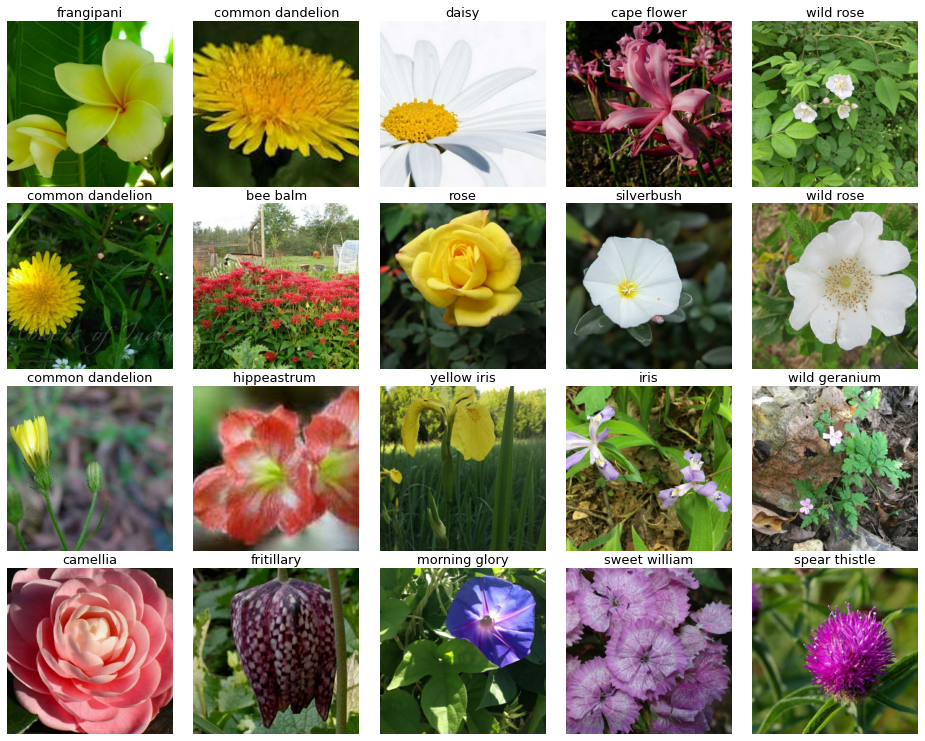

In [15]:
training_dataset = get_training_dataset()
temp_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(temp_dataset)
display_batch_of_images(next(train_batch))

# Nick's ConvNet

In [16]:
model_optimizer_string = 'adam'
model_loss_string = 'sparse_categorical_crossentropy'
model_accuracy_string = 'sparse_categorical_accuracy'

def create_model():
    choice = 2
    net_dict = {1: "MobileNetV2", 2: "Xception", 3: "VGG16", 4: "ResNet50", 5: "MobileNet"}
    net = net_dict[choice]
    
    if net == "MobileNetV2":
        pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    if net == "Xception":
        pretrained_model = tf.keras.applications.Xception(weights='imagenet',input_shape=[*IMAGE_SIZE, 3], include_top=False)
    if net == "VGG16":
        pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    if net == "ResNet50":
        pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    if net == "MobileNet":
        pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(CLASSES), activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(CLASSES), activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
#         tf.keras.layers.GlobalAveragePooling2D(),
#         #tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(len(CLASSES), activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
    ])

    model.compile(
        optimizer=model_optimizer_string,
        loss = model_loss_string,
        metrics=[model_accuracy_string]
    )

    return model

# Mason's ConvNet

In [17]:
model_optimizer_string = 'adam'
model_loss_string = 'sparse_categorical_crossentropy'
model_accuracy_string = 'sparse_categorical_accuracy'

# def create_model():
#     choice = 2
#     net_dict = {1: "MobileNetV2", 2: "Xception", 3: "VGG16", 4: "ResNet50", 5: "MobileNet"}
#     net = net_dict[choice]
    
#     if net == "MobileNetV2":
#         pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#     if net == "Xception":
#         pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#     if net == "VGG16":
#         pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#     if net == "ResNet50":
#         pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#     if net == "MobileNet":
#         pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        
#     pretrained_model.trainable = True

#     model = tf.keras.Sequential([
#         pretrained_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         #tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(len(CLASSES), activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
#     ])

#     model.compile(
#         optimizer=model_optimizer_string,
#         loss = model_loss_string,
#         metrics=[model_accuracy_string]
#     )

#     return model

# Riley's ConvNet

In [18]:
# def create_model():
#     choice = 2
#     net_dict = {1: "MobileNetV2", 2: "Xception", 3: "VGG16", 4: "ResNet50", 5: "MobileNet"}
#     net = net_dict[choice]
    
#     if net == "MobileNetV2":
#         pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#     if net == "Xception":
#         pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#     if net == "VGG16":
#         pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#     if net == "ResNet50":
#         pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#     if net == "MobileNet":
#         pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        
#     pretrained_model.trainable = True

#     model = tf.keras.Sequential([
#         pretrained_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         #tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(len(CLASSES), activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
#     ])

#     model.compile(
#         optimizer=model_optimizer_string,
#         loss = model_loss_string,
#         metrics=[model_accuracy_string]
#     )

#     return model

Things to try:
* Conv2D(kernel_size=3, filters=30, padding='same', activation='relu')
* MaxPooling2D(pool_size=2)
* tf.keras.layers.GlobalAveragePooling2D() # / Flatten()
* Dense(90, activation='relu')

* pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])\n
* pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])\n
* pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])\n
* pretrained_model.trainable = False # False = transfer learning, True = fine-tuning


In [19]:
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
_________________________________________________________________
dropout (Dropout)            (None, 104)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               10920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________

In [20]:
start_time = time.time()
history = model.fit(get_training_dataset(), validation_data=get_validation_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_"+model_accuracy_string][-5:]
total_time = time.time() - start_time
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", total_time, " sec")

file_name = "history.csv"
pd.DataFrame(history.history).to_csv(file_name)
writeToCSV = open(file_name, 'a')
# Pass the file handle in as a lambda function to make it callable
model.summary(print_fn=lambda x: writeToCSV.write(x + '\n'))
writeToCSV.write("Accuracy,"+str(np.mean(final_accuracy))+"\n")
writeToCSV.write("TRAINING TIME,"+ str(total_time) + ",sec\n")
writeToCSV.write("loss function,"+ model_loss_string)
writeToCSV.write("metrics,"+ model_accuracy_string)
writeToCSV.write("optimizer,"+ model_optimizer_string)
writeToCSV.close()

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
99/99 [==============================] - 48s 487ms/step - loss: 4.6146 - sparse_categorical_accuracy: 0.0451 - val_loss: 4.6107 - val_sparse_categorical_accuracy: 0.0560

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/100
99/99 [==============================] - 12s 122ms/step - loss: 4.3888 - sparse_categorical_accuracy: 0.0644 - val_loss: 4.2332 - val_sparse_categorical_accuracy: 0.0563

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/100
99/99 [==============================] - 16s 158ms/step - loss: 3.9710 - sparse_categorical_accuracy: 0.1434 - val_loss: 3.7648 - val_sparse_categorical_accuracy: 0.1894

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/100
99/99 [==============================] - 17s 171ms/step - loss: 3.3139 - sparse_categorical_accuracy: 0.2751 - val_loss: 3.4372 - val_spars

In [21]:
# def display_confusion_matrix(cmat, score, precision, recall):
#     plt.figure(figsize=(15,15))
#     ax = plt.gca()
#     ax.matshow(cmat, cmap='Reds')
#     ax.set_xticks(range(len(CLASSES)))
#     ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
#     ax.set_yticks(range(len(CLASSES)))
#     ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
#     plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#     titlestring = ""
#     if score is not None:
#         titlestring += 'f1 = {:.3f} '.format(score)
#     if precision is not None:
#         titlestring += '\nprecision = {:.3f} '.format(precision)
#     if recall is not None:
#         titlestring += '\nrecall = {:.3f} '.format(recall)
#     if len(titlestring) > 0:
#         ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
#     plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


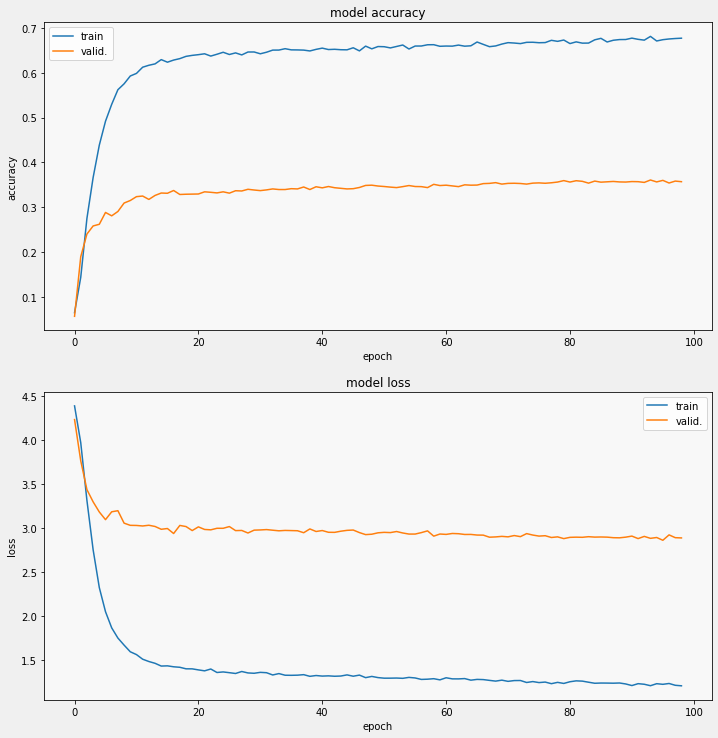

In [22]:
print(history.history.keys())
display_training_curves(history.history[model_accuracy_string][1:], history.history["val_"+model_accuracy_string][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [23]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [24]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

sub = pd.read_csv("submission.csv")
sub.to_csv("submission.csv",index=False)

Computing predictions...
[67 28 68 ... 39 47 65]
Generating submission.csv file...


Image Shape (512, 512, 3)


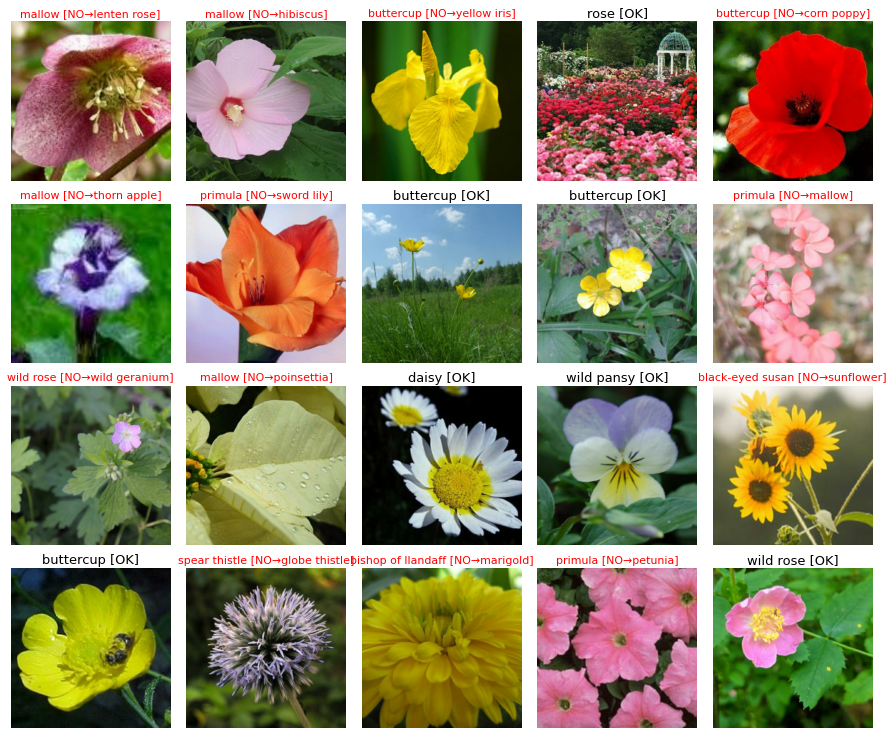

In [25]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)